## Advanced Lane Finding Project

The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

### Collecting camera calibration matrix and distortion coefficients

In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import scipy
from scipy import signal
from moviepy.editor import VideoFileClip
%matplotlib inline

out_dir='./output_images/'

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(10)
        image_name=os.path.split(fname)[1]
        write_name = out_dir+'undistorted_'+image_name
        cv2.imwrite(write_name,img)
        print(write_name)

cv2.destroyAllWindows()


./output_images/undistorted_calibration10.jpg
./output_images/undistorted_calibration11.jpg
./output_images/undistorted_calibration12.jpg
./output_images/undistorted_calibration13.jpg
./output_images/undistorted_calibration14.jpg
./output_images/undistorted_calibration15.jpg
./output_images/undistorted_calibration16.jpg
./output_images/undistorted_calibration17.jpg
./output_images/undistorted_calibration18.jpg
./output_images/undistorted_calibration19.jpg
./output_images/undistorted_calibration2.jpg
./output_images/undistorted_calibration20.jpg
./output_images/undistorted_calibration3.jpg
./output_images/undistorted_calibration6.jpg
./output_images/undistorted_calibration7.jpg
./output_images/undistorted_calibration8.jpg
./output_images/undistorted_calibration9.jpg


### Calibrate the camera and Undistort the image

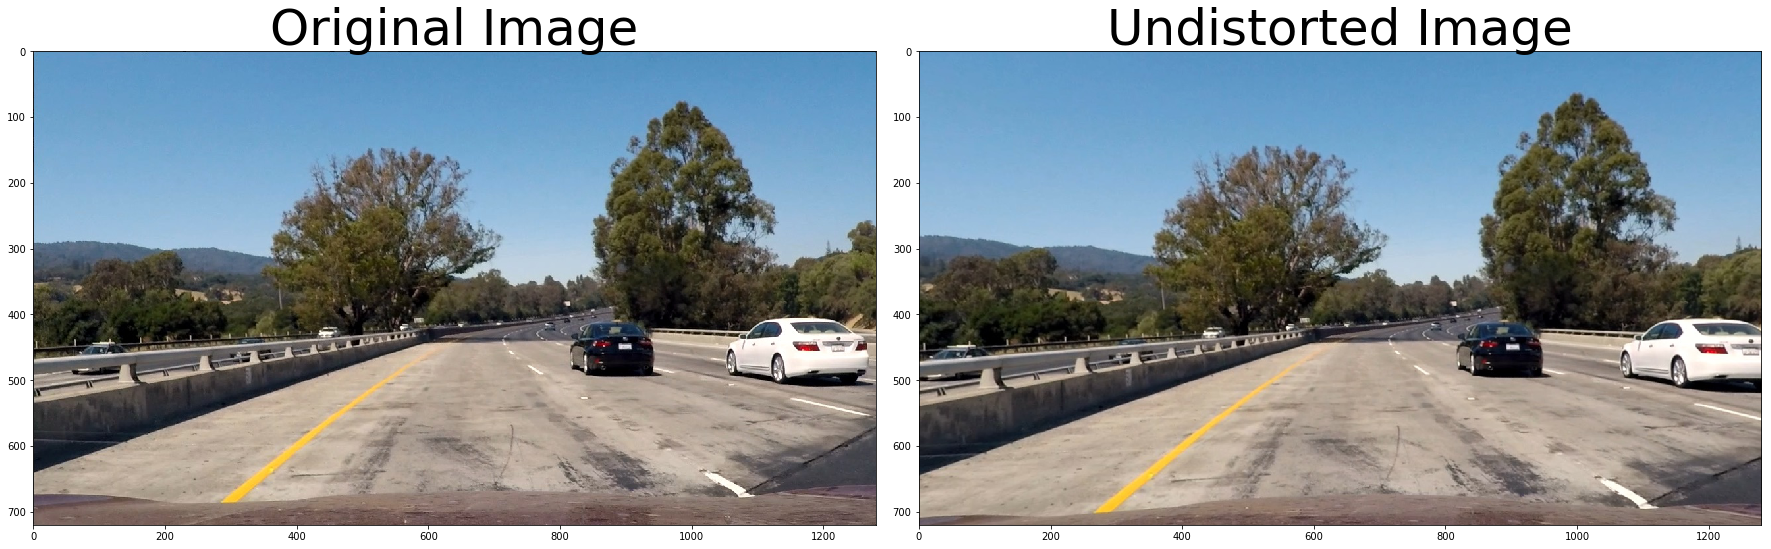

In [2]:
def undist_img(img):
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

img = cv2.imread('./camera_cal/calibration2.jpg')
img2 = mpimg.imread('./test_images/test1.jpg')
dst = undist_img(img)
dst2 = undist_img(img2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst2)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Thresholded binary image creation

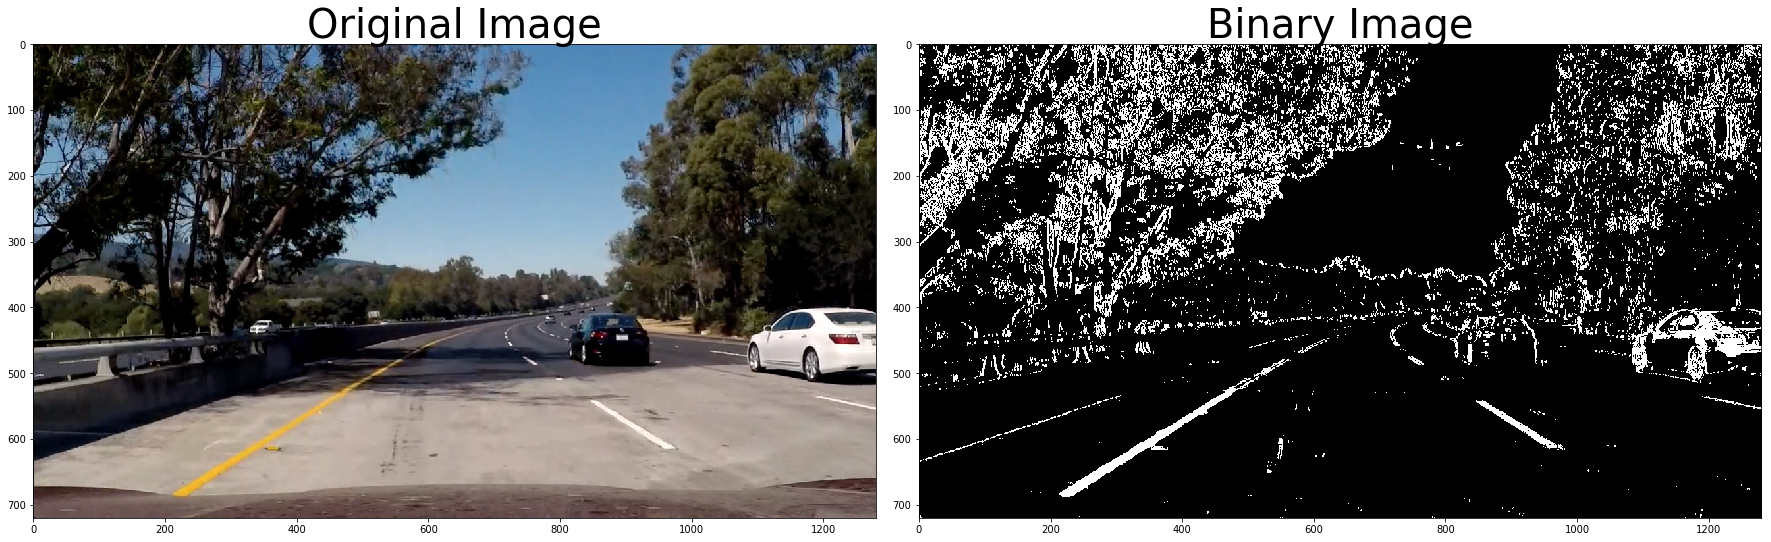

In [3]:
def binary_image(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
          
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary

image = mpimg.imread('./test_images/test5.jpg')
img_binary = binary_image(image)
    
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(img_binary)
ax2.set_title('Binary Image', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective Transform

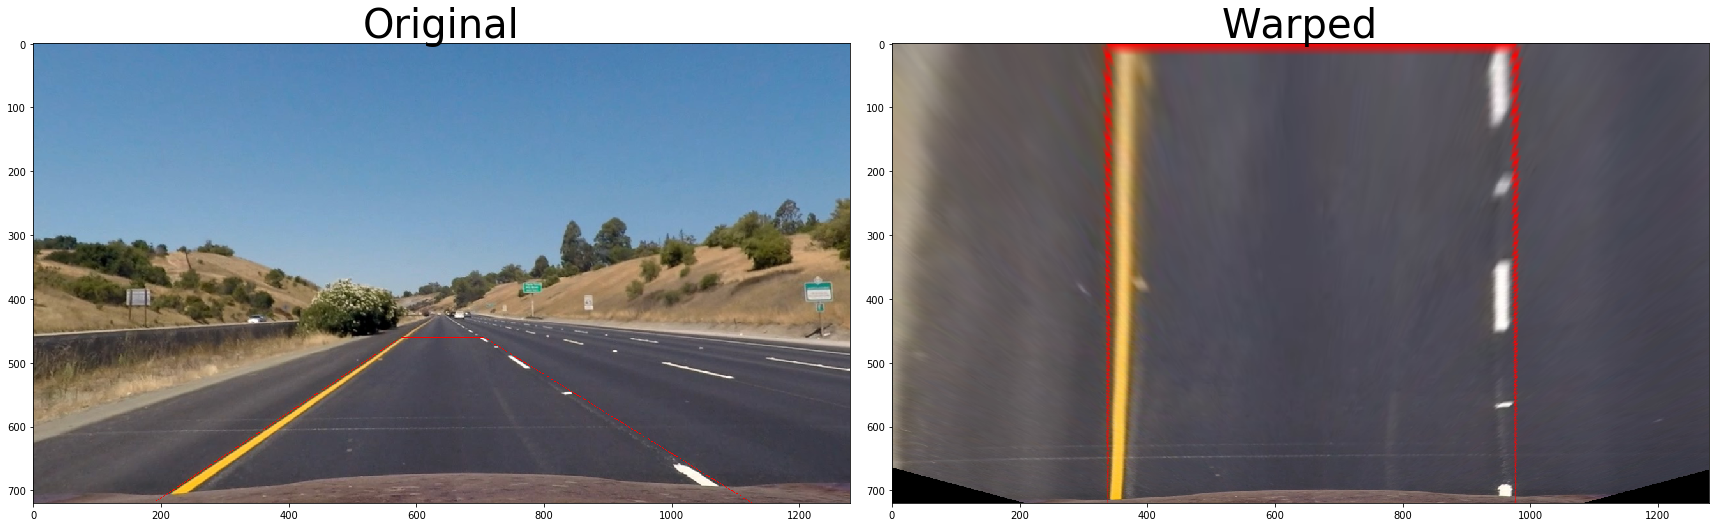

In [4]:
def warp(img,bird_eye=True):
    corners = np.float32([[188,720],[576,460],[706,460],[1126,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if bird_eye:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

image = mpimg.imread('./test_images/straight_lines1.jpg')
img = undist_img(image)
plt.imsave('./output_images/undist_straight_lines1.jpg',img)
corners = np.float32([[188,720],[576,460],[706,460],[1126,720]])
imshape = img.shape

corner_tuples=[]
for ind,c in enumerate(corners):
    corner_tuples.append(tuple(corners[ind]))

cv2.line(img, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=1)

warp_img,_ = warp(img) 

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img,cmap='gray')
ax1.set_title('Original', fontsize=40)

ax2.imshow(warp_img,cmap='gray')
ax2.set_title('Warped', fontsize=40)

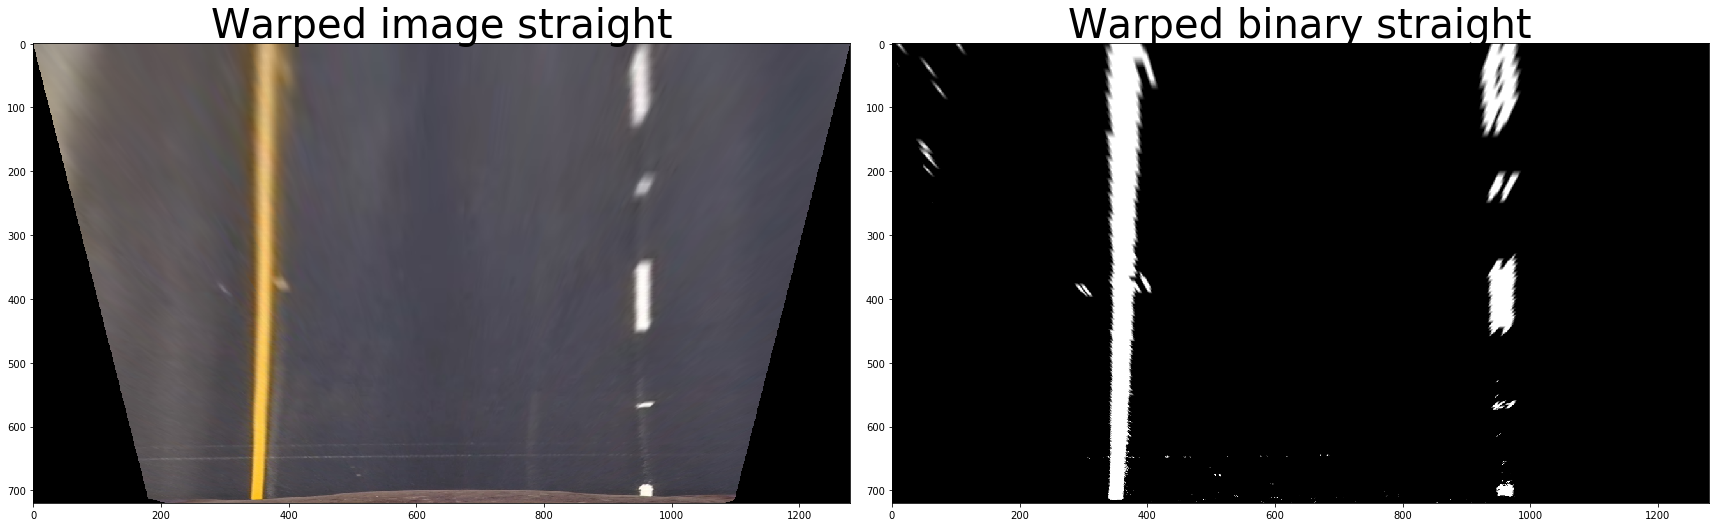

In [5]:
def roi(img):
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def warp_pipe(img):
    undist = undist_img(img)    
    result,_ = warp(undist)
    result = roi(result)
    return result
    
def warp_binary_pipe(img):
    undist = undist_img(img)
    binary  = binary_image(undist)
    result,_  = warp(binary)
    result = roi(result)
    return result 

image = mpimg.imread('./test_images/straight_lines1.jpg')
warp_str = warp_pipe(image)
warp_binary_str = warp_binary_pipe(image)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warp_str)
ax1.set_title('Warped image straight', fontsize=40)

ax2.imshow(warp_binary_str,cmap='gray')
ax2.set_title('Warped binary straight', fontsize=40)

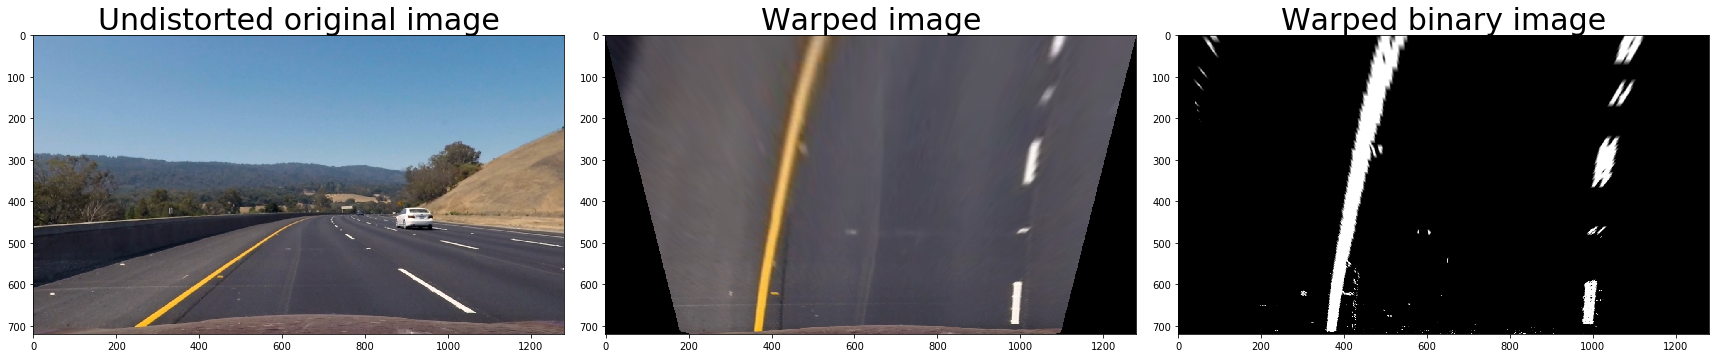

In [6]:
img=plt.imread('./test_images/test3.jpg')
_undist_img = undist_img(img)
warped = warp_pipe(img)
binary_warped = warp_binary_pipe(img)

# Plot the result
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(_undist_img)
ax1.set_title('Undistorted original image', fontsize=30)

ax2.imshow(warped)
ax2.set_title('Warped image', fontsize=30)

ax3.imshow(binary_warped,cmap='gray')
ax3.set_title('Warped binary image', fontsize=30)

### Detect lane pixels and fit to find the lane boundary

In [7]:
def get_LineFit(img):
    binary_warp_t = img.copy()
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warp_t.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warp_t.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create an output image to draw on and  visualize the result
    out_img = binary_warp_t.copy()

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warp_t[binary_warp_t.shape[0]//2:,:], axis=0)
    filtered = scipy.ndimage.filters.gaussian_filter(histogram,sigma=20)
    #plt.plot(filtered)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(filtered.shape[0]/2)
    # left lane starting point
    leftx_base = np.argmax(filtered[:midpoint], axis=0)
    # right lane starting point
    rightx_base = np.argmax(filtered[midpoint:], axis=0) + midpoint
    # Current positions to be updated for each window
    leftx_current = leftx_base[0]
    rightx_current = rightx_base[0]
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warp_binary_str.shape[0] - (window+1)*window_height
        win_y_high = warp_binary_str.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    #print(left_lane_inds,right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit,right_fit

In [40]:
def detect_lanelines(img):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    binary_warp_t2 = img.copy()
    _left_fit, _right_fit = get_LineFit(binary_warp_t2)
    nonzero = binary_warp_t2.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (_left_fit[0]*(nonzeroy**2) + _left_fit[1]*nonzeroy + _left_fit[2] - margin)) & (nonzerox < (_left_fit[0]*(nonzeroy**2) + _left_fit[1]*nonzeroy + _left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (_right_fit[0]*(nonzeroy**2) + _right_fit[1]*nonzeroy + _right_fit[2] - margin)) & (nonzerox < (_right_fit[0]*(nonzeroy**2) + _right_fit[1]*nonzeroy + _right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warp_t2.shape[0]-1, binary_warp_t2.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = binary_warp_t2.copy()
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/625 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Get line positions
    left_line_pos = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_line_pos = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Calculate offset
    basepos = 640
    diff = (left_line_pos + right_line_pos)/2
    offset = (diff - basepos) * xm_per_pix # Convert to cm
    return ploty,left_fitx,right_fitx, left_curverad, right_curverad, offset, out_img

In [43]:
def process_image(img):
    # This undistorted image is used to display the final image
    _undist_img = undist_img(img)
    # warp_binary_pipe() does the image undistortion, hence the original image is passed 
    binary_warp_t3 = warp_binary_pipe(img)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warp_t3).astype(np.uint8)
    color_warp = warp_zero.copy()
    
    _ploty, _left_fitx, _right_fitx, _left_curverad, _right_curverad, _offset, _out_img = detect_lanelines(binary_warp_t3)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([_left_fitx, _ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([_right_fitx, _ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    _,Minv = warp(img,bird_eye=False)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    fill_warp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    lanelines_warp = cv2.warpPerspective(_out_img, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    newwarp = cv2.addWeighted(lanelines_warp, 0.7, fill_warp, 0.3, 0)
    result = cv2.addWeighted(_undist_img, 1, newwarp, 1, 0)
    str1 = str('Offset: '+str(_offset)+'m')
    cv2.putText(result,str1,(430,630), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2,cv2.LINE_AA)
    
    if _left_curverad and _right_curverad:
        curvature = 0.5*(round(_right_curverad/1000,1) + round(_left_curverad/1000,1))
        str2 = str('Radius of curvature: '+str(curvature)+'km')
        cv2.putText(result,str2,(430,670), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2,cv2.LINE_AA)
    return result

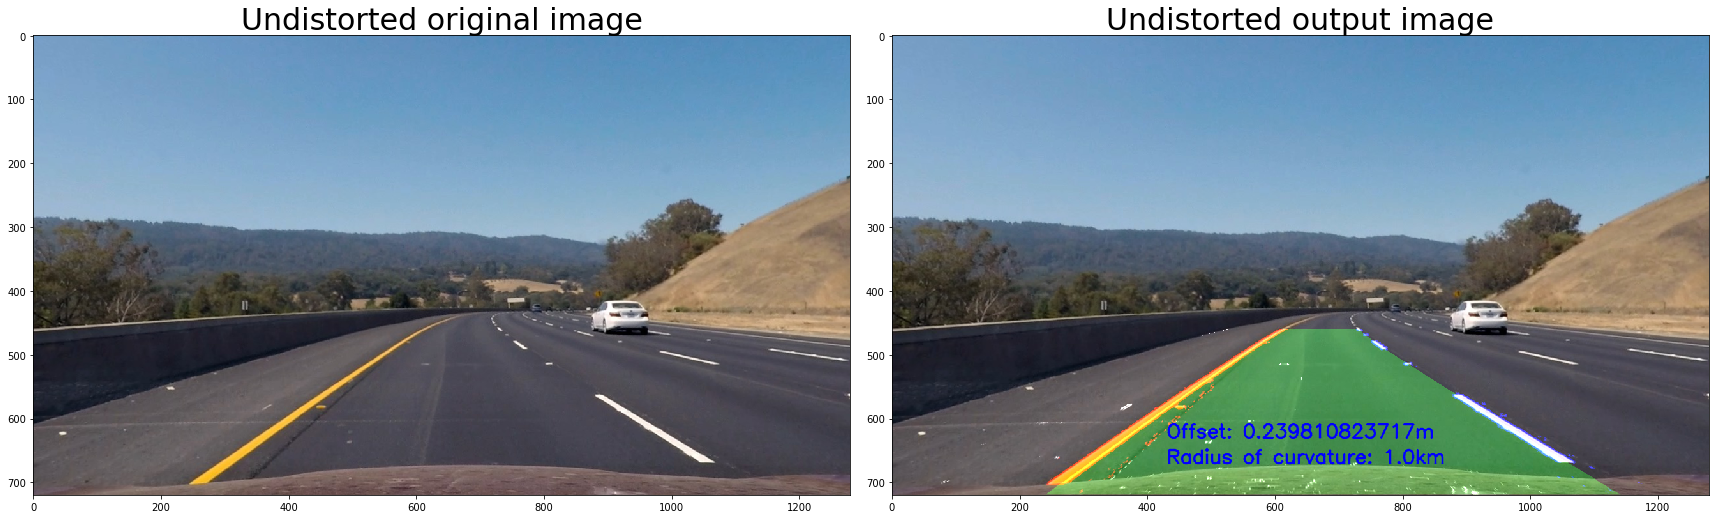

In [44]:
img=plt.imread('./test_images/test3.jpg')
_undist_img = undist_img(img)
result = process_image(img)

# Plot the result
f, (ax1,ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(_undist_img)
ax1.set_title('Undistorted original image', fontsize=30)

ax2.imshow(result)
ax2.set_title('Undistorted output image', fontsize=30)

In [45]:
out_dir='./'
output = out_dir+'processed_project_video.mp4'
#clip = VideoFileClip("project_video.mp4").subclip(0,5)
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:05:29<00:03,  3.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

Wall time: 1h 5min 30s
